In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import cvxopt
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from scipy.optimize import fmin_l_bfgs_b as lbfgs
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator
import substring_kernel as subker
import regex

In [7]:
def _get_data(filename, header=None, index_col=None):
    if header is None:
        return pd.read_csv(filename, header=header).values.tolist()
    else:
        return pd.read_csv(filename).values.tolist()

In [8]:
train_files = ['data/Xtr0.csv', 'data/Xtr1.csv', 'data/Xtr2.csv']
test_files = ['data/Xte0.csv', 'data/Xte1.csv', 'data/Xte2.csv']
label_files = ['data/Ytr0.csv', 'data/Ytr1.csv', 'data/Ytr2.csv']


train_dna = np.asarray([_get_data(filename) for filename in train_files])
test_dna = np.asarray([_get_data(filename) for filename in test_files])

label_dna = np.asarray([np.asarray(_get_data(filename, header=True))[
                       :, 1] for filename in label_files])

In [9]:
train_dna.shape

(3, 2000, 1)

In [10]:
test_dna.shape

(3, 1000, 1)

In [11]:
label_dna.shape

(3, 2000)

(array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

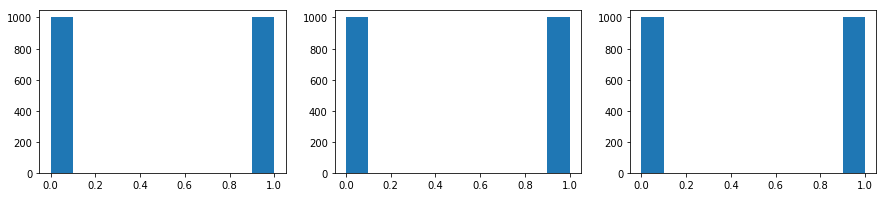

In [12]:
plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.hist(label_dna[0])
plt.subplot(132)
plt.hist(label_dna[1])
plt.subplot(133)
plt.hist(label_dna[2])

In [13]:
dna_dict2 = np.array(["".join(item) for item in itertools.product("ATCG", repeat=2)])
dna_dict3 = np.array(["".join(item) for item in itertools.product("ATCG", repeat=3)])

dna_dict = dna_dict3

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} P x + q^\top x
  \\
   & \textrm{s.t.}\; A x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

See documentation: http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [14]:
def qp(P, q, A, b, C, verbose=True):
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    G = cvxopt.matrix(np.concatenate(
        [np.diag(-np.ones(n)), np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)], axis=0))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    if A is None or b is None:
        solution = cvxopt.solvers.qp(P, q, G, h, solver='mosec')
    else:
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
        solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')

    return np.ravel(solution['x'])

In [15]:
def normalize_kernel(kernel):
    """
    Normalizes a kernel: kernel[x, y] by doing:
        kernel[x, y] / sqrt(kernel[x, x] * kernel[y, y])
    """

    nkernel = np.copy(kernel).astype(float)

    assert nkernel.ndim == 2
    assert nkernel.shape[0] == nkernel.shape[1]

    for i in range(nkernel.shape[0]):
        for j in range(i + 1, nkernel.shape[0]):
            q = np.sqrt(nkernel[i, i] * nkernel[j, j])
            if q > 0:
                nkernel[i, j] = float(nkernel[i, j])/q
                nkernel[j, i] = nkernel[i, j]  # symmetry

    # finally, set diagonal elements to 1
    np.fill_diagonal(nkernel, 1.)

    return nkernel

## Kernels

In [16]:
def spectrum_kernel (chainsA, chainsB):
    chainsA = np.atleast_1d(chainsA)
    chainsB = np.atleast_1d(chainsB)
    matA = np.array([[chain[0].count(word) for chain in chainsA] for word in dna_dict])
    matB = np.array([[chain[0].count(word) for chain in chainsB] for word in dna_dict])
    return np.squeeze(np.dot(matA.T, matB))

In [17]:
def spectrum_norm_kernel (chainsA, chainsB):
    chainsA = np.atleast_1d(chainsA)
    chainsB = np.atleast_1d(chainsB)
    matA = np.array([[chain[0].count(word) for chain in chainsA] for word in dna_dict])
    matB = np.array([[chain[0].count(word) for chain in chainsB] for word in dna_dict])
    return cosine_similarity(matA.T, matB.T)

In [18]:
def mismatch_kernel(chainsA, chainsB, k=3, m=0):
    chainsA = np.atleast_1d(chainsA)
    chainsB = np.atleast_1d(chainsB)

    NVocab = {}
    vocab = np.array(["".join(item) for item in itertools.product("ATCG", repeat=k)])
    n_vocab = len(vocab)
    idx = dict(zip(vocab, range(len(vocab))))
    all_seq = "".join(vocab)
    for kmer in vocab:
        neighbors = regex.findall("(" + kmer + ")" + "{s<=" + str(m) + "}", all_seq, overlapped=True)
        NVocab[kmer] = list(np.unique(neighbors))
        
    specA = []
    for chain in chainsA:
        spec = np.zeros(n_vocab)
        n = len(chain[0])
        for offset in range(n - k):
            kmer = chain[0][offset: offset + k]
            for nb in NVocab[kmer]:
                spec[idx[kmer]] += 1
        specA.append(spec)
    specA = np.asarray(specA)
        
    specB = []
    for chain in chainsB:
        spec = np.zeros(n_vocab)
        n = len(chain[0])
        for offset in range(n - k):
            kmer = chain[0][offset: offset + k]
            for nb in NVocab[kmer]:
                spec[idx[kmer]] += 1
        specB.append(spec)
    specB = np.asarray(specB)
        
    return cosine_similarity(specA, specB)

In [19]:
def substringKernel_cpp_nystrom(chainsA, chainsB, lbda=0.1, word_size=4, sample_size=100):
    chainsA = np.atleast_1d(chainsA)
    sample = np.random.choice(chainsA.size, sample_size, replace=False)
    res = subker.getKernel(lbda, word_size, chainsA, chainsA[sample]).reshape(
        [chainsA.size, sample_size])
    mat = res[sample]
    w, v = np.linalg.eig(mat)
    w = w.real
    v = v.real
    ind = w > 1e-6
    v1 = v[:, ind]
    w1 = np.diag(1 / w[ind])
    almost_inverse = v1.dot(w1.dot(np.transpose(v1)))
    res = res.dot(almost_inverse.dot(np.transpose(res)))
    return np.squeeze(res)

In [21]:
def substringKernel_cpp(chainsA, chainsB ,lbda = 0.1, word_size = 4):
    chainsA = np.atleast_1d(chainsA)
    chainsB = np.atleast_1d(chainsB)
    res = subker.getKernel(lbda, word_size, chainsA, chainsB).reshape([chainsA.size, chainsB.size])
    return np.squeeze(res)

## Test setup

In [22]:
# test using random split (20% of the data used as validation set)
def test_random_split(clf):
    scores = []
    for idx_data in range(3):
        X = train_dna[idx_data]
        y = label_dna[idx_data]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=.2, stratify=y, random_state=42)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(clf.score(y_test, y_pred))
    return scores

In [23]:
# test using 3 fold crossvalidation
def test_crossval(clf):
    scores = []
    for idx_data in range(3):
        X = train_dna[idx_data]
        y = label_dna[idx_data]
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        cv_scores = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            cv_scores.append(clf.score(y_test, y_pred))
        scores.append(np.mean(cv_scores))
    return scores

## SVM

In [24]:
class SVM (BaseEstimator):
    def __init__(self, lbda=1.0, kernel='spectrum_kernel', **kargs):
        self.lbda = lbda
        self.kargs = kargs
        self.kernel_ = kernel
        if kernel == 'mismatch_kernel':
            self.kernel = mismatch_kernel
        elif kernel == 'spectrum_kernel':
            self.kernel = spectrum_kernel
        elif kernel == 'spectrum_norm_kernel':
            self.kernel = spectrum_norm_kernel
        elif kernel == 'substring_kernel':
            self.kernel = substringKernel_cpp_nystrom
            self.test_kernel = substringKernel_cpp
        else:
            print ('Invalid kernel')
        
 
    def _dual_solver(self, K, C, y):
        n = K.shape[0]
        P = np.zeros([n, n])
        for i in range(n):
            for j in range(n):
                P[i][j] = K[i][j] * y[i] * y[j]
        q = -np.ones(n)
        A = np.reshape(1. * y, (1, n))
        b = .0
        alpha = qp(P, q, A, b, C, verbose=False)
        return alpha
 
    def fit(self, X_train, y_train):
       
        self.X_train = X_train
        self.y_train = y_train
        self.y_train[self.y_train == 0] = -1
 
        n = X_train.shape[0]
        C = 1 / (2 * self.lbda * n)
        K = self.kernel(X_train, X_train, **self.kargs)
 
        # solve optimization problem
        self._alpha = self._dual_solver(K, C, self.y_train)
 
        # index for support vector
        idx = np.argmax(
            np.min([np.abs(self._alpha), np.abs(self._alpha - C)], axis=0))
        self.bias = self._alpha.dot(K[:, idx] * self.y_train) - self.y_train[idx]
        return self
 
    def predict(self, X_test):
        if self.kernel_ != 'substring_kernel':
            K = self.kernel(self.X_train, X_test, **self.kargs)
        else:
            K = self.test_kernel(self.X_train, X_test, **self.kargs)
        y_pred = np.sign(np.dot(K.T, self._alpha * self.y_train) - self.bias).astype(int)
        y_pred[y_pred < 0] = 0
        return y_pred
        
    def score(self, y_true, y_pred):
        return np.sum(y_pred == y_true).astype(float) / np.size(y_true)

## Testing SVM

### Mismatch kernel

In [19]:
def test_mismatch_kernel(k, m):
    params = [.001, .0001, .00001, .000001]
    svm_scores = {}
    for lbda in params:
        print ("lbda %.6f ..." % lbda)
        clf = SVM(lbda, kernel='mismatch_kernel', k=k, m=m)
        svm_scores[lbda] = test_crossval(clf)
        print (svm_scores[lbda])

In [20]:
test_mismatch_kernel(k=3, m=0)

lbda 0.0010 ...
[0.6629938321555088, 0.7360174545803289, 0.6004852157546768]
lbda 0.0001 ...
[0.6685008361655068, 0.7540010069950189, 0.6159992327656999]
lbda 0.0000 ...
[0.6640008271744798, 0.7474959989930049, 0.6219902537267806]
lbda 0.0000 ...
[0.6579933226639815, 0.7529925134715554, 0.6119877362392332]


In [21]:
test_mismatch_kernel(k=3, m=1)

lbda 0.0010 ...
[0.6629938321555088, 0.7360174545803289, 0.6004852157546768]
lbda 0.0001 ...
[0.6685008361655068, 0.7540010069950189, 0.6159992327656999]
lbda 0.0000 ...
[0.6640008271744798, 0.7474959989930049, 0.6219902537267806]
lbda 0.0000 ...
[0.6579933226639815, 0.7529925134715554, 0.6119877362392332]


In [26]:
test_mismatch_kernel(k=4, m=0)

lbda 0.001000 ...
[0.7155149161137185, 0.8375021728315142, 0.6125017232801664]
lbda 0.000100 ...
[0.7060084036131941, 0.8404916892940845, 0.6089907272542003]
lbda 0.000010 ...
[0.6905018791246337, 0.833988179796563, 0.6004957052861245]
lbda 0.000001 ...
[0.6930058801316287, 0.8280001558444671, 0.6064882247516978]


In [25]:
test_mismatch_kernel(k=4, m=1)

lbda 0.001000 ...
[0.7155149161137185, 0.8375021728315142, 0.6125017232801664]
lbda 0.000100 ...
[0.7060084036131941, 0.8404916892940845, 0.6089907272542003]
lbda 0.000010 ...
[0.6905018791246337, 0.833988179796563, 0.6004957052861245]
lbda 0.000001 ...
[0.6930058801316287, 0.8280001558444671, 0.6064882247516978]


In [25]:
test_mismatch_kernel(k=4, m=2)

lbda 0.001000 ...
[0.7155149161137185, 0.8375021728315142, 0.6125017232801664]
lbda 0.000100 ...
[0.7060084036131941, 0.8404916892940845, 0.6089907272542003]
lbda 0.000010 ...
[0.6905018791246337, 0.833988179796563, 0.6004957052861245]
lbda 0.000001 ...
[0.6930058801316287, 0.8280001558444671, 0.6064882247516978]


In [27]:
test_mismatch_kernel(k=5, m=0)

lbda 0.001000 ...
[0.7355094615573657, 0.8535166903430377, 0.605502208795622]
lbda 0.000100 ...
[0.7139774505043966, 0.8315051578524632, 0.6015012018006031]
lbda 0.000010 ...
[0.6844943746141352, 0.8045275814736893, 0.5895056733380087]
lbda 0.000001 ...
[0.6779983576390762, 0.8045275814736893, 0.5874826922731115]


In [26]:
test_mismatch_kernel(k=5, m=1)

lbda 0.001000 ...
[0.7355094615573657, 0.8535166903430377, 0.605502208795622]
lbda 0.000100 ...
[0.7139774505043966, 0.8315051578524632, 0.6015012018006031]
lbda 0.000010 ...
[0.6844943746141352, 0.8045275814736893, 0.5895056733380087]
lbda 0.000001 ...
[0.6779983576390762, 0.8045275814736893, 0.5874826922731115]


In [27]:
test_mismatch_kernel(k=5, m=2)

lbda 0.001000 ...
[0.7355094615573657, 0.8535166903430377, 0.605502208795622]
lbda 0.000100 ...
[0.7139774505043966, 0.8315051578524632, 0.6015012018006031]
lbda 0.000010 ...
[0.6844943746141352, 0.8045275814736893, 0.5895056733380087]
lbda 0.000001 ...
[0.6779983576390762, 0.8045275814736893, 0.5874826922731115]


In [29]:
test_mismatch_kernel(k=6, m=0)

lbda 0.001000 ...
[0.7374964785144426, 0.8510186833540127, 0.6155017292741843]
lbda 0.000100 ...
[0.7064744385103666, 0.8505061948175721, 0.5845036653419887]
lbda 0.000010 ...
[0.7019744295193396, 0.8510066953180727, 0.5864996733260207]
lbda 0.000001 ...
[0.7019744295193396, 0.8510066953180727, 0.5864996733260207]


In [28]:
test_mismatch_kernel(k=6, m=1)

lbda 0.001000 ...
[0.7374964785144426, 0.8510186833540127, 0.6155017292741843]
lbda 0.000100 ...
[0.7064744385103666, 0.8505061948175721, 0.5845036653419887]
lbda 0.000010 ...
[0.7019744295193396, 0.8510066953180727, 0.5864996733260207]
lbda 0.000001 ...
[0.7019744295193396, 0.8510066953180727, 0.5864996733260207]


### Spectrum Kernel

In [31]:
# modified spectrum kernel
params = [.001, .0001, .00001, .000001]
svm_scores = {}
for lbda in params:
    print ("lbda %.6f ..." % lbda)
    clf = SVM(lbda, kernel='spectrum_norm_kernel')
    svm_scores[lbda] = test_crossval(clf)
    print (svm_scores[lbda])

lbda 0.001000 ...
[0.6714933496370622, 0.7390114665563767, 0.6144812477147806]
lbda 0.000100 ...
[0.6745023466580352, 0.753502004999011, 0.628481775188362]
lbda 0.000010 ...
[0.6654933376490263, 0.7514985044925164, 0.6244792696888505]
lbda 0.000001 ...
[0.6644968321615029, 0.7544955134775494, 0.6139777502052951]


In [28]:
params = [.001, .0001, .00001, .000001]
svm_scores = {}
for lbda in params:
    print ("lbda %.6f ..." % lbda)
    clf = SVM(lbda, kernel='spectrum_kernel')
    svm_scores[lbda] = test_crossval(clf)
    print (svm_scores[lbda])

lbda 0.001000 ...
[0.6709973446500394, 0.7539965114815415, 0.6204842567118015]
lbda 0.000100 ...
[0.6740003476530423, 0.7510099920279562, 0.6154897412382443]
lbda 0.000010 ...
[0.6720028411645179, 0.7515074955194715, 0.6159902417387447]
lbda 0.000001 ...
[0.6730038421655188, 0.7515074955194715, 0.6154912397427368]


### Substring Kernel

In [25]:
params = [.001]
svm_scores = {}
for lbda in params:
    print ("lbda %.6f ..." % lbda)
    clf = SVM(lbda, kernel='substring_kernel')
    svm_scores[lbda] = test_crossval(clf)
    print (svm_scores[lbda])

lbda 0.001000 ...
[0.7075099051146955, 0.8154846463229698, 0.6250082417747089]


  ## Kernel logistic regression

In [27]:
class KLR (BaseEstimator):
    def __init__(self, lbda=1.0, kernel='spectrum_kernel', **kargs):
        self.lbda = lbda
        self.kargs = kargs
        self.kernel_ = kernel
        if kernel == 'mismatch_kernel':
            self.kernel = mismatch_kernel
        elif kernel == 'spectrum_kernel':
            self.kernel = spectrum_kernel
        elif kernel == 'spectrum_norm_kernel':
            self.kernel = spectrum_norm_kernel
        elif kernel == 'substring_kernel':
            self.kernel = substringKernel_cpp_nystrom
            self.test_kernel = substringKernel_cpp
        else:
            print ('Invalid kernel')

    def _rgloss(self, x):
        return np.log(1. + np.exp(-x))

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))

    def _rgloss_prime(self, x):
        return -self._sigmoid(-x)

    def _f(self, x):
        n = self._K.shape[0]
        reg = 0.5 * self.lbda * np.dot(np.dot(self._K, x), x)
        fx = np.sum(self._rgloss(self._y * np.dot(self._K, x)) / n) + reg
        return fx

    def _fprime(self, x):
        n = self._K.shape[0]
        yKx = self._y * np.dot(self._K, x)
        grad = np.dot(self._K.T, (self._y * self._rgloss_prime(yKx))
                      ) / n + self.lbda * np.dot(self._K, x)
        return grad

    def _solver(self, x0):
        alpha, _, _ = lbfgs(self._f, x0, fprime=self._fprime)
        return alpha

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = np.copy(y_train)
        self.y_train[self.y_train == 0] = -1
        self._y = self.y_train

        n = X_train.shape[0]
        self._K = self.kernel(X_train, X_train, **self.kargs)

        # solve optimization problem
        x0 = np.zeros(n)
        self._alpha = self._solver(x0)

        return self

    def predict(self, X_test):
        if self.kernel_ != 'substring_kernel':
            K = self.kernel(self.X_train, X_test, **self.kargs)
        else:
            K = self.test_kernel(self.X_train, X_test, **self.kargs)
        y_pred = np.sign(np.dot(K.T, self._alpha)).astype(int)
        y_pred[y_pred < 0] = 0
        return y_pred

    def score(self, y_true, y_pred):
        return np.sum(y_pred == y_true).astype(float) / len(y_true)

## Testing Kernel Logistic Regression

### Mismatch kernel

In [34]:
def test_mismatch_kernel(k, m):
    params = [.001, .0001, .00001, .000001]
    klr_scores = {}
    for lbda in params:
        print ("lbda %.6f ..." % lbda)
        clf = KLR(lbda, kernel='mismatch_kernel', k=k, m=m)
        klr_scores[lbda] = test_crossval(clf)
        print (klr_scores[lbda])

In [35]:
test_mismatch_kernel(3, 0)

lbda 0.001000 ...
[0.6665003326679972, 0.7445154735573897, 0.6129842417267567]
lbda 0.000100 ...
[0.6644953336570103, 0.753502004999011, 0.6189782596968225]
lbda 0.000010 ...
[0.6634958311605018, 0.7569935204665743, 0.6149862437287587]
lbda 0.000001 ...
[0.6630058201914489, 0.7574910239580898, 0.6084887282492072]


In [36]:
test_mismatch_kernel(3, 1)

lbda 0.001000 ...
[0.6670008331684979, 0.7445154735573897, 0.6129842417267567]
lbda 0.000100 ...
[0.6639948331565098, 0.753502004999011, 0.6194787601973231]
lbda 0.000010 ...
[0.6644953336570104, 0.7569935204665743, 0.6139852427277577]
lbda 0.000001 ...
[0.662999826173479, 0.7574925224625823, 0.6139807472142801]


In [37]:
test_mismatch_kernel(3, 2)

lbda 0.001000 ...
[0.6665003326679972, 0.7445154735573897, 0.6129842417267567]
lbda 0.000100 ...
[0.6639978301654949, 0.7540025054995114, 0.6189782596968225]
lbda 0.000010 ...
[0.6634943326560093, 0.7574940209670747, 0.6199792606978236]
lbda 0.000001 ...
[0.6630043216869564, 0.7579900259540978, 0.6134787482092872]


In [38]:
test_mismatch_kernel(4, 1)

lbda 0.001000 ...
[0.7150069230907555, 0.8490136843430256, 0.6174947402492313]
lbda 0.000100 ...
[0.7145034255812699, 0.8539962117806429, 0.6199942457427486]
lbda 0.000010 ...
[0.7070064076052099, 0.8379936823050596, 0.6084977192761625]
lbda 0.000001 ...
[0.6975088861316406, 0.8289921658185131, 0.6134997272721824]


In [39]:
test_mismatch_kernel(4, 2)

lbda 0.001000 ...
[0.7150069230907555, 0.8490136843430256, 0.6184957412502322]
lbda 0.000100 ...
[0.7155014295732859, 0.8539962117806429, 0.6189932447417478]
lbda 0.000010 ...
[0.7090069111027195, 0.8394951838065611, 0.6074997152841464]
lbda 0.000001 ...
[0.6965108821396248, 0.8259996523469577, 0.6109957262651874]


In [40]:
test_mismatch_kernel(5, 1)

lbda 0.001000 ...
[0.744501987016957, 0.85601319882757, 0.6240072407737078]
lbda 0.000100 ...
[0.7259954565343788, 0.8525111938285591, 0.6110017202831574]
lbda 0.000010 ...
[0.6944893995792198, 0.8305176433918948, 0.5940056823290356]
lbda 0.000001 ...
[0.6799913686141231, 0.8260221299143455, 0.583489177800555]


In [41]:
test_mismatch_kernel(6, 1)

lbda 0.001000 ...
[0.7399944855034676, 0.8510126893360427, 0.6150042257826689]
lbda 0.000100 ...
[0.7394879909849971, 0.8735007462552372, 0.6140002277726829]
lbda 0.000010 ...
[0.7294749839660019, 0.8670047292801785, 0.6059967152781524]
lbda 0.000001 ...
[0.722966978955003, 0.8670047292801785, 0.5930031828235421]


### Spectrum Normalized Kernel

In [81]:
# modified spectrum kernel using cosine similarity
params = [.01, .001, .0001, .00001, .000001]
klr_scores = {}
for lbda in params:
    print ("lbda %.4f ..." % lbda)
    clf = KLR(lbda, kernel='spectrum_norm_kernel')
    klr_scores[lbda] = test_crossval(clf)
    print (klr_scores[lbda])

lbda 0.0100 ...
[0.6630043216869564, 0.6975028921136706, 0.5929807052561543]
lbda 0.0010 ...
[0.6679958401515288, 0.7490109870349392, 0.6194757631883381]
lbda 0.0001 ...
[0.6729903556250861, 0.7539965114815415, 0.6214732696768624]
lbda 0.0000 ...
[0.6749893606181031, 0.7544970119820421, 0.6209787631943321]
lbda 0.0000 ...
[0.6694943446440452, 0.7589985194775615, 0.6189752626878375]


In [31]:
# modified spectrum kernel using cosine similarity
params = [.01, .001, .0001, .00001, .000001]
klr_scores = {}
for lbda in params:
    print ("lbda %.4f ..." % lbda)
    clf = KLR(lbda, kernel='spectrum_kernel')
    klr_scores[lbda] = test_crossval(clf)
    print (klr_scores[lbda])

lbda 0.0100 ...


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


[0.558058058058058, 0.5, 0.5]
lbda 0.0010 ...
[0.5570570570570571, 0.5, 0.5]
lbda 0.0001 ...
[0.5570570570570571, 0.5, 0.5]
lbda 0.0000 ...
[0.5575575575575575, 0.5, 0.5]
lbda 0.0000 ...
[0.5570570570570571, 0.5, 0.5]


### Substring Kernel

In [28]:
params = [.01, .001, .0001]
klr_scores = {}
for lbda in params:
    print ("lbda %.4f ..." % lbda)
    clf = KLR(lbda, kernel='substring_kernel')
    klr_scores[lbda] = test_crossval(clf)
    print (klr_scores[lbda])

lbda 0.0100 ...
[0.688489387591184, 0.7535214855574136, 0.5994857132581684]
lbda 0.0010 ...
[0.7045054036071999, 0.8244906583229937, 0.6164712616808425]
lbda 0.0001 ...
[0.7000068931206656, 0.8294971618324912, 0.6180012347677019]


## Kaggle submission

In [43]:
def substringKernel_cpp(chainsA, chainsB, lbda=0.1, word_size=4):
    chainsA = np.atleast_1d(chainsA)
    chainsB = np.atleast_1d(chainsB)
    res = subker.getKernel(lbda, word_size, chainsA, chainsB).reshape(
        [chainsA.size, chainsB.size])
    return np.squeeze(res)

SVM(kernel=<function spectrum_norm_kernel at 0x7f117452bb70>, lbda=0.0001)

In [44]:
ypreds = [clf1.predict(test_dna[0]), clf2.predict(test_dna[1]), clf3.predict(test_dna[2])]

In [45]:
allpreds = pd.DataFrame(np.atleast_1d(ypreds).flatten(), columns=['Bound'])
allpreds.index.name = 'Id'
allpreds = allpreds.reset_index()
allpreds.head()

,Id,Bound
0,0,0
1,1,1
2,2,0
3,3,0
4,4,1


In [46]:
allpreds.to_csv('submission_final2.csv', index=False)